# OPERA Surface Displacement from Sentinel-1 Access and Visualize

Authors: Harshini Girish (UAH), Rajat Shinde (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed)

Date:July 16, 2025

Description: In this tutorial aims to provide information and code to help users get started working with the OPERA Sentinel-1 Surface Displacement product using the MAAP. We will search for the data within NASA’s Common Metadata Repository (CMR)

## Run This Notebook

To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the “Getting started with the MAAP” section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.



## About the Data

The Level-3 OPERA Sentinel-1 Surface Displacement (DISP) product is generated through interferometric time-series analysis of Level-2 Coregistered Sentinel-1 Single Look Complex (CSLC) datasets. Using a hybrid Persistent Scatterer (PS) and Distributed Scatterer (DS) approach, this product quantifies Earth's surface displacement in the radar line-of-sight. The DISP products enable the detection of anthropogenic and natural surface changes, including subsidence, tectonic deformation, and landslides. 

The OPERA DISP suite comprises complementary datasets derived from Sentinel-1 and NISAR inputs, designated as DISP-S1 and DISP-NI, respectively. Each product, created per acquisition, adheres to a consistent structure, HDF5 file format, file-naming convention, and a 30 m spatial posting. This collection specifically includes DISP-S1 products, derived from Sentinel-1 data. For visualization and quick exploration, the Pangeo Image can be used for these datasets. 


Source: [OPERA Surface Displacement from Sentinel-1](https://cmr.earthdata.nasa.gov/search/concepts/C3294057315-ASF.html)

## Importing Packages

You can access data from Jupyter Notebook within your workspace. In your Jupyter Notebook, start by importing the `maap` package. Then invoke the `MAAP` constructor, setting the `maap_host` argument to `'api.maap-project.org'`


In [14]:
from maap.maap import MAAP
import xarray as xr
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import folium
from shapely.geometry import box
from shapely.geometry import Polygon
import geopandas as gpd
# Initialize MAAP
maap = MAAP()


## Searching the Data

This performs a granule search using the `maap.searchGranule()` function on the OPERA Sentinel-1 displacement product collection.

In [14]:
collection = maap.searchCollection(
    cmr_host="cmr.earthdata.nasa.gov",
    short_name="OPERA_L3_DISP-S1_V1"
)
len(collection)

1

In [15]:

concept_id = collection[0]["concept-id"]
print(concept_id)


C3294057315-ASF


In [27]:
results = maap.searchGranule(
    concept_id=concept_id,
    cmr_host="cmr.earthdata.nasa.gov",
    limit=100
)

records = []
for r in results:
    granule = r["Granule"]
    try:
        points = granule["Spatial"]["HorizontalSpatialDomain"]["Geometry"]["GPolygon"]["Boundary"]["Point"]
        coords = [(float(p["PointLongitude"]), float(p["PointLatitude"])) for p in points]
        if len(coords) >= 3:
            polygon = Polygon(coords)
            records.append({
                "GranuleUR": granule["GranuleUR"],
                "geometry": polygon
            })
    except KeyError:
        continue
if records:
    gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")
    print(f"Found {len(gdf)} granules with polygons.")

    

Found 100 granules with polygons.


## Visualizing with Bounding Boxes

In [28]:
bounding_boxes = []
granule_ids = []

for i, geom in enumerate(gdf.geometry):
    minx, miny, maxx, maxy = geom.bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))  
    granule_ids.append(gdf["GranuleUR"][i])


bbox_gdf = gpd.GeoDataFrame({
    "GranuleUR": granule_ids,
    "geometry": bounding_boxes
}, crs="EPSG:4326")


map_center = bbox_gdf.geometry.union_all().centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=6)


for _, row in bbox_gdf.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda x: {
            "color": "green",
            "weight": 2,
            "fillOpacity": 0.1
        },
        tooltip=row["GranuleUR"]
    ).add_to(m)

m


## Search Granules using filters

### Temporal Filter

Now that we have our collection ID, let’s search for granules within the collection. We’ll also add a temporal filter to our search. If you would like to search for granules without the temporal filter, simply comment out or remove the `temporal=date_range` line.

In [10]:
date_range = "2016-07-01T00:00:00Z,2016-07-25T23:59:59Z"

results = maap.searchGranule(
    temporal=date_range,
    concept_id="C3294057315-ASF",
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160818T005800Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161029T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170310T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170403T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170202T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170214T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170226T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161005T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170322T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_201607

### Spatial Filter

Another filter we can apply is a spatial filter.

In [11]:
granule_bbox = "-104.57446,23.91956,-101.85669,25.95518" 
collection_id = "C3294057315-ASF"

results = maap.searchGranule(
    concept_id=collection_id,
    bounding_box=granule_bbox,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160818T005800Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161029T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170310T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170403T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170202T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170214T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170226T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161005T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170322T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_201607

## Granule Link Search

This code snippet queries the CMR for OPERA DISP-S1 Level-3 .nc granules using `maap.searchGranule()`. It loops through the search results, extracts links from the OnlineAccessURLs, and filters for .nc files. It then prints the corresponding HTTPS and S3 URLs for each NetCDF granule, allowing users to choose between direct download or cloud-native access for analysis.

In [28]:
results = maap.searchGranule(short_name="OPERA_L3_DISP-S1_V1", cmr_host="cmr.earthdata.nasa.gov", limit=4)

for g in results:
    for l in g.get("Granule", {}).get("OnlineAccessURLs", {}).get("OnlineAccessURL", []):
        if l["URL"].endswith(".nc"):
            print("Download URL:", l["URL"])


Download URL: https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc
Download URL: s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc
Download URL: https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z.nc
Download URL: s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z.nc
Download URL: https://datapool.asf.alaska.edu/DISP/OPERA-S1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160818T005800Z_v1.0_20250412T124848Z.nc
Download URL: s3://asf-cumulus-prod-opera-products/OPERA_L3_D

## Download and Inspect 

In this section, the .nc (NetCDF) file is first downloaded from the provided granule URL using the requests library and saved locally. This file contains geospatial raster data structured with multiple variables and coordinates. Once saved, it is opened using `xarray.open_dataset()`, which loads the dataset into memory and exposes its metadata and data variables.

In [24]:
url = results[0]["Granule"]["OnlineAccessURLs"]["OnlineAccessURL"][0]["URL"]
response = requests.get(url)
with open("downloaded_file.nc", "wb") as f:
    f.write(response.content)
print("Downloaded successfully.")


Downloaded successfully.


In [25]:
ds = xr.open_dataset("downloaded_file.nc")
ds = xr.open_dataset("downloaded_file.nc", engine="h5netcdf")
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:                         (y: 8036, x: 9614, time: 1)
Coordinates:
  * y                               (y) float64 64kB 2.881e+06 ... 2.64e+06
  * x                               (x) float64 77kB 5.339e+05 ... 8.223e+05
  * time                            (time) datetime64[ns] 8B 2016-07-25T00:57...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float32 309MB ...
    short_wavelength_displacement   (y, x) float32 309MB ...
    recommended_mask                (y, x) float32 309MB ...
    connected_component_labels      (y, x) float32 309MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 309MB ...
    persistent_scatterer_mask       (y, x) float32 309MB ...
    shp_counts                      (y, x) float32 309MB ...
    water_mask                      (y, x) float32 309MB

## Visualization

The `.squeeze()` function removes dimensions of length one from the xarray DataArray, simplifying the shape for plotting. The `.plot()` method then renders the 2D displacement data with specified color limits and colormap for clearer visualization.

In [26]:
ds["displacement"].attrs


{'units': 'meters',
 'description': 'Displacement along the radar Line-of-Sight (LOS) direction. Positive values indicate apparent motion towards the platform.',
 'long_name': 'Line-of-sight displacement',
 'grid_mapping': 'spatial_ref'}

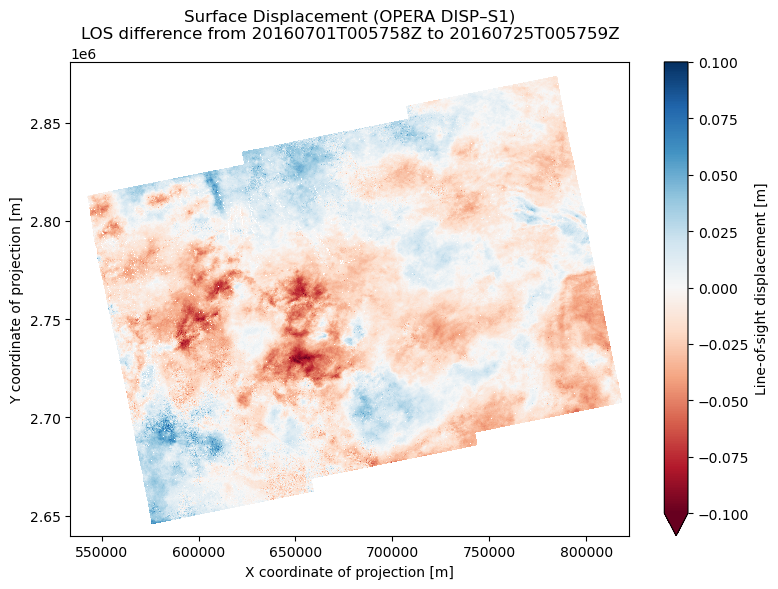

In [29]:
import re

# Extract URL
url = results[0]["Granule"]["OnlineAccessURLs"]["OnlineAccessURL"][0]["URL"]

# Extract start and end datetimes using regex
match = re.search(r'_(\d{8}T\d{6}Z)_(\d{8}T\d{6}Z)', url)
start_date, end_date = match.group(1), match.group(2)

# Plotting
disp = ds["displacement"].squeeze()
disp.plot(
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    figsize=(8, 6),
    cbar_kwargs={"label": "Line-of-sight displacement [m]"}
)
plt.title(f"Surface Displacement (OPERA DISP–S1)\nLOS difference from {start_date} to {end_date}")
plt.xlabel("X coordinate of projection [m]")
plt.ylabel("Y coordinate of projection [m]")
plt.tight_layout()
plt.show()


## S3 access

This code securely streams a `.nc` file directly from an ASF-hosted S3 bucket using temporary AWS credentials via `fsspec`. The file is opened in-memory with `h5py`, allowing inspection of its dataset keys without downloading the file locally.

In [42]:
maap = MAAP(maap_host="api.maap-project.org")


results = maap.searchGranule(
    concept_id="C3294057315-ASF",
    cmr_host="cmr.earthdata.nasa.gov",
    limit=10,
)


print(results[0].getDownloadUrl())


credentials = maap.aws.earthdata_s3_credentials(
    'https://cumulus.asf.alaska.edu/s3credentials'
)


s3 = fsspec.filesystem(
    "s3",
    key=credentials['accessKeyId'],
    secret=credentials['secretAccessKey'],
    token=credentials['sessionToken']
)



s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc


In [ ]:
with s3.open(results[0].getDownloadUrl(), "rb") as f:
    opera_data = h5py.File(f, "r")
    print(opera_data.keys())  
    

## Visualization

The plot shows pixel-level surface displacement values without downloading the file locally.

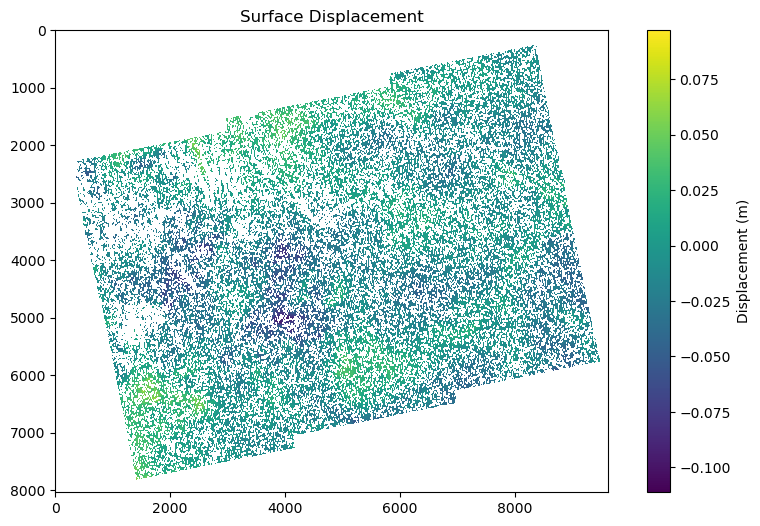

In [40]:
with s3.open(results[0].getDownloadUrl(), "rb") as f:
    opera_data = h5py.File(f, "r")
    displacement_data = opera_data["displacement"][:]
    displacement_data = np.ma.masked_where(np.isnan(displacement_data), displacement_data)
    match = re.search(r'_(\d{8}T\d{6}Z)_(\d{8}T\d{6}Z)', url)
    start_date, end_date = match.groups() if match else ("Unknown", "Unknown")

    plt.figure(figsize=(10, 6))
    plt.imshow(displacement_data, cmap="viridis")
    plt.title(f"Surface Displacement\nLOS difference from {start_date} to {end_date}")
    plt.colorbar(label="Displacement (m)")
    plt.title("Surface Displacement")
    plt.show()
